<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/main/notebooks/Toy_Simulator_gradients_stochasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To study the impact of gradients stochasticity, we want to create a toy simulator which meets the following requirements:


*   $p(\theta |y ) \: \perp \!\!\!\!\! \perp \:$ number of latent variables $z$.

  $\Rightarrow p(y | \theta) \: \perp \!\!\!\!\! \perp \:$ number of latent variables $z$.


*   $p(y|\theta) \ne p(y)$



*   $SNR = \frac{\mathbb{E}_{z}[\nabla_{\theta}(\log p(\theta |y, z))]}{\mathbb{V}ar_{z}[\nabla_{\theta}(\log p(\theta |y, z))]}$ decreases with the number of latent variables $z$.





#Imports

In [ ]:
!pip install --quiet jax==0.3.25
!pip install --quiet dm-haiku==0.0.5
!pip install --quiet optax==0.1.4
!pip install --quiet flax==0.6.3
!pip install --quiet chainconsumer
!pip install --quiet numpyro==0.10.1
!pip install --quiet jax-cosmo===0.1rc9
!pip install --quiet git+https://github.com/Justinezgh/SBI-Diff-Simulator.git

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sbids 0.0.1 requires jax-cosmo>=0.1.0, but you have jax-cosmo 0.1rc9 which is incompatible.
  Preparing metadata (setup.py) ... done


In [ ]:
%pylab inline 
import jax 
import jax.numpy as jnp 
import numpyro 
from numpyro.handlers import seed, trace, condition, substitute 
import numpyro.distributions as dist 
from numpyro.contrib.control_flow import cond 

from functools import partial 
from tqdm import tqdm 

import tensorflow_probability as tfp
tfp = tfp.substrates.jax
tfd= tfp.distributions

import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

import seaborn as sns 
import arviz as az
sns.set_theme()

from sbids.tasks.utils import get_samples_and_scores

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cond', 'trace', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Simulator

$N = $ number of latent variables $z$.


$\theta \sim \mathcal{N}(0, 0.1)$

$z_0=0$

for $i=1 \: ... \: N -10$:

> $z_i \sim \mathcal{N}(z_{i-1}, 0.1)$


for $i=N-10 \: ... \: N$:

> $z_i \sim \mathcal{N}(z_{i-1}, sigmoid(\theta \times z_{i-1})$

$y \sim \mathcal{N}(5\theta + \frac{z_{N}}{\ln(N)}, 0.5)$

In [ ]:
def sigmoid_(x):
    return 1. / (1. + jnp.exp(-x))

def simulator_1(nb_latent_variables):

  theta = numpyro.sample('theta', dist.Normal(0.,0.1))
  z = 0.

  for i in range(nb_latent_variables - 10):
    z = numpyro.sample('z%d' %i, dist.Normal(z, 0.1))

  for i in range(nb_latent_variables - 10, nb_latent_variables):
    z = numpyro.sample('z%d' %i, dist.Normal(z, sigmoid_(theta * z)))

  y = numpyro.sample(
      'y', 
      dist.Normal((z / jnp.log(nb_latent_variables)) + 5 * theta, 0.5)
  )

  return y

Explanation of the simulator construction:

<ipython-input-44-0909c7a7b4b1>:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  subplot(1, 2, 1)
<ipython-input-44-0909c7a7b4b1>:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  subplot(1, 2, 1)
<ipython-input-44-0909c7a7b4b1>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

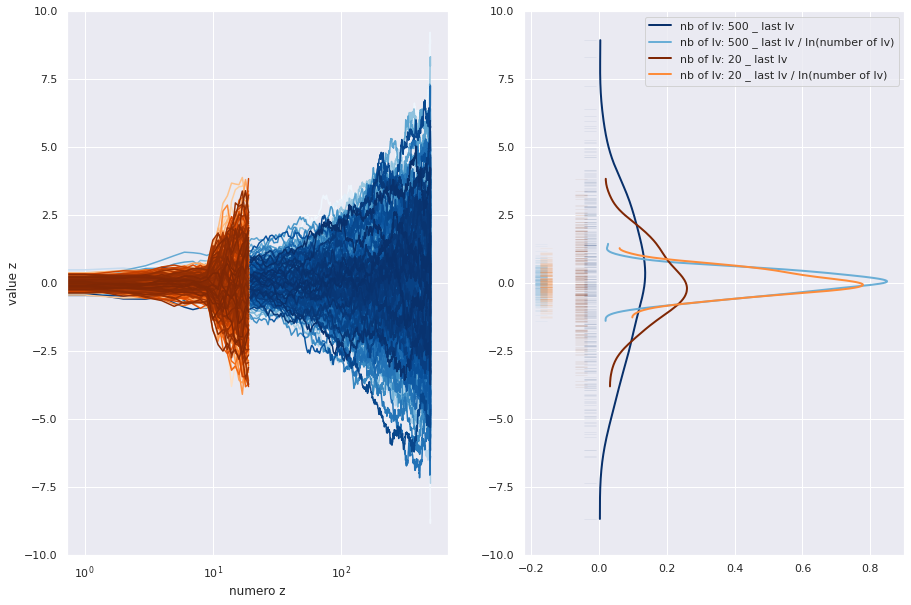

In [ ]:
figure(figsize = (15,10))
c=0
nb = 400
colors = [
    plt.cm.Blues(np.linspace(0, 1, nb)),
    plt.cm.Oranges(np.linspace(0, 1, nb))
]

master_key = jax.random.PRNGKey(0)

for nb_latent_variables in [500, 20]:

  last_z = []
  last_z_rescaled = []

  for i in range(nb):
    master_key, keys = jax.random.split(master_key, 2)
    col = colors[c]

    model = seed(
        partial(
            simulator_1, 
            nb_latent_variables = nb_latent_variables
        ), 
        keys
    )

    model_trace = trace(model).get_trace()

    data = [model_trace['z%d'%i]['value'] for i in range(nb_latent_variables)]
    last_z.append(data[-1])
    last_z_rescaled.append(data[-1]/ jnp.log(nb_latent_variables))

    subplot(1, 2, 1)
    #title('nb of latent variables %d' %nb_latent_variables)
    plot(range(nb_latent_variables), data, c=col[i])
    xscale('log')
    ylim([-10, 10])
    xlabel('numero z')
    ylabel('value z')

  subplot(1, 2, 2)
  az.plot_kde(
    np.array(last_z),
    label="nb of lv: %d _ last lv" % nb_latent_variables,
    rug=True,
    plot_kwargs={"linewidth": 2, "c":col[i]},
    rug_kwargs={"alpha": 0.05},
    rotated=True
  )
  az.plot_kde(
    np.array(last_z_rescaled),
    label="nb of lv: %d _ last lv / ln(number of lv)" % nb_latent_variables,
    rug=True,
    plot_kwargs={"linewidth": 2,"c":col[nb // 2]},
    rug_kwargs={"alpha": 0.05},
    rotated=True
  )
  ylim([-10, 10])
  c+=1

* Based on this I constructed the likelihood in a way that the first requirement is (approximatively) checked:

$$\mathcal{N}\Big(\frac{\text{last z}}{\ln \: (\text{number of latent variables})} \:, 0.5\Big)$$


* Then, to meet the second requirement I added:

$$\mathcal{N}\Big(5 \theta + \frac{\text{last z}}{\ln \: (\text{number of latent variables})} \: , 0.5\Big)$$

* Score definition: 
$$\nabla_{\theta}\log p(\theta | y, z ) = \nabla_{\theta}\log p(y | \theta, z) + \nabla_{\theta}\log p( z| \theta ) + \nabla_{\theta}\log p(\theta) \: \: \text{with } \: \:z = z_{1}, ..., z_{N}$$
$$\text{and} \: \: \nabla_{\theta}\log p( z| \theta ) = \nabla_{\theta}\log p( z_1| \theta ) + \nabla_{\theta}\log p( z_2| \theta, z_1 ) \: + \: ... \: + \: \nabla_{\theta} \log p( z_N| \theta, z_1, z_2, ..., z_{N-1} )$$
meaning that unless the aleatoric variables $ X_i = \nabla_{\theta}\log p( Z_i| \theta,  Z_1, ...Z_{i-1})$ are sampled from the same distribution (CLT) the score will be shifted as the number of latent variables N increases. 

However, to meet the last requirement we would like that $\mathbb{E}_{z}[\nabla_{\theta}(\log p(\theta |y, z))]$ remains the same and that $V = \mathbb{V}ar_{z}[\nabla_{\theta}(\log p(\theta |y, z))]$ increases with N. To do so I fixed the number of latent variables $z$ depending of $\theta$ to $10$. In particular, to have $V$ increases with $N$ I considered the 10 last latent variables.

⏭ Now we check all the requirements:

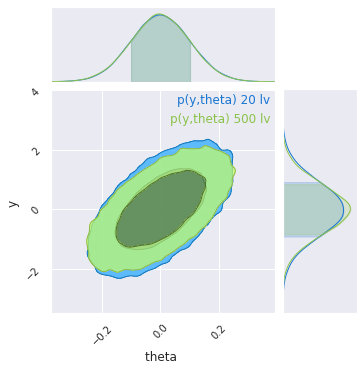

In [ ]:
# first and second requirement:

from chainconsumer import ChainConsumer

master_key = jax.random.PRNGKey(0)

nb_latent_variables = 20
model = partial(
    simulator_1, 
    nb_latent_variables = nb_latent_variables
)
master_key, keys = jax.random.split(master_key)
(_, samples_20), _ = get_samples_and_scores(
    model, 
    keys, 
    batch_size=50000, 
    score_type='density', 
)

nb_latent_variables = 500
model = partial(
    simulator_1, 
    nb_latent_variables = nb_latent_variables
)
master_key, keys = jax.random.split(master_key)
(_, samples_500), _ = get_samples_and_scores(
    model, 
    keys, 
    batch_size=50000, 
    score_type='density', 
)

c = ChainConsumer()
c.add_chain(samples_20, name='p(y,theta) 20 lv')
c.add_chain(samples_500, name='p(y,theta) 500 lv')
fig = c.plotter.plot(figsize="column")

100%|██████████| 3/3 [11:21<00:00, 227.08s/it]


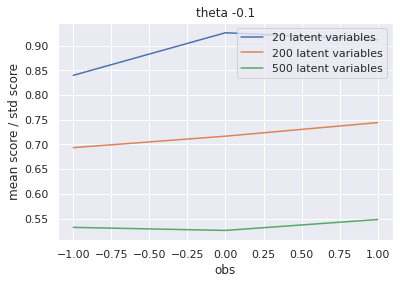

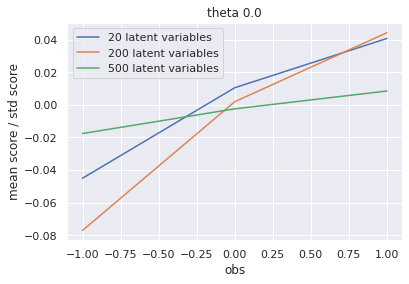

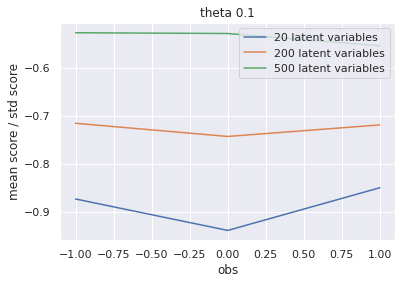

In [ ]:
from tqdm import tqdm

for theta in tqdm([-0.1, 0., 0.1]):
  x = [ -1 , 0, 1]

  error_var = 10000

  store_snr = {'20_rows': {}, '200_rows': {},'500_rows': {}}

  for nb_latent_variables in tqdm([20,200,500]):

    store_snr[
        '{}_rows'.format(nb_latent_variables)
    ][
        'theta_{}'.format(theta)
    ] = []


    model = partial(
        simulator_1,
        nb_latent_variables = nb_latent_variables
    )

    cond_model = condition(model, {'theta': round(theta, 1), 
                                      })

    for bin in x:
      master_key = jax.random.PRNGKey(0)
      master_key, keys = jax.random.split(master_key)
      (_, samples), scores = get_samples_and_scores(
          cond_model, 
          keys, 
          batch_size=10000, 
          score_type='density'
      )
        
      indx = jnp.where(round(samples['y']) == bin)[0]

      count = 0
      if indx.shape[0] != 0 :

        while indx.shape[0] < error_var : 
          master_key, keys = jax.random.split(master_key)
          (_, samples), scores = get_samples_and_scores(
              cond_model, 
              keys, 
              batch_size=10000, 
              score_type='density', 
              thetas=None
          )
          indx = jnp.concatenate([
              indx, 
              jnp.where(round(samples['y']) == bin)[0]
          ])
          count += 1

          if count > int(error_var/10) : 
            indx = jnp.array([], dtype=jnp.int32)
            break

      if len(jnp.array(indx).squeeze()) > error_var : 
        indx = indx[:error_var] 


      store_snr[
          '{}_rows'.format(nb_latent_variables)
      ][
          'theta_{}'.format(theta)
      ].append(
          jnp.mean(scores[indx]) / jnp.std(scores[indx])
      )

  plt.figure()
  col = 0
  for nb_rows in [20, 200, 500]:
    plt.plot(
        x,
        store_snr['{}_rows'.format(nb_rows)]['theta_{}'.format(theta)],
        c = 'C%d'%col
    )
    col +=1
    
  plt.title('theta %s' % theta)
  plt.xlabel('obs')
  plt.ylabel('mean score / std score')
  plt.legend([
      '20 latent variables',
      '200 latent variables',
      '500 latent variables'
  ])

# SBI


In [ ]:
import jax.numpy as jnp
import jax
import haiku as hk
import optax

import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

from sbids.models import AffineSigmoidCoupling, ConditionalRealNVP
from functools import partial
bijector_layers = [128] * 2

bijector_npe = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers, 
  n_components=16, 
  activation=jax.nn.silu
)

NF_npe = partial(
  ConditionalRealNVP, 
  n_layers=4, 
  bijector_fn=bijector_npe)

In [ ]:
prior = tfd.Normal(0, 0.1)
theta = prior.sample(10000, jax.random.PRNGKey(67))
scale_theta = (jnp.std(theta, axis=0)/0.06)
shift_theta = jnp.mean(theta/scale_theta, axis=0)-0.5

class SmoothNPE(hk.Module):
    def __call__(self, y):
        net = y
        nvp = NF_npe(1)(net)
        return tfd.TransformedDistribution(nvp,
                                          tfb.Chain([tfb.Scale(scale_theta),
                                                      tfb.Shift(shift_theta)]))
        
nvp_nd_npe = hk.without_apply_rng(hk.transform(lambda theta,y : SmoothNPE()(y).log_prob(theta).squeeze()))
nvp_nd_npe_prob = hk.without_apply_rng(hk.transform(lambda theta,y : SmoothNPE()(y).prob(theta).squeeze()))
nvp_sample_nd_npe = hk.transform(lambda x: SmoothNPE()(x).sample(1000, seed=hk.next_rng_key()))

# define loss function and model update
def loss_fn(params, weight, mu, batch, score):
  log_prob, out = jax.vmap(
    jax.value_and_grad(lambda theta, x: nvp_nd_npe.apply(params, theta.reshape([1,1]), x.reshape([1,-1])).squeeze())
    )(mu, batch)
  return  -jnp.mean(log_prob) + weight * jnp.mean(jnp.sum((out - score)**2, axis=1))

@jax.jit
def update(params, opt_state, weight, mu, batch, score):
    """Single SGD update step."""
    loss, grads  = jax.value_and_grad(loss_fn)(params, weight, mu, batch, score)
    updates, new_opt_state = optimizer_npe.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [ ]:
import tensorflow as tf
from flax.metrics import tensorboard

nb_of_simu_allowed = 5000
nb_step = 5000
nb_latent_variables = 20
score_weight=0

model = partial(simulator_1, nb_latent_variables = nb_latent_variables)
( _ , samples), scores = get_samples_and_scores(
    model, 
    jax.random.PRNGKey(10), 
    batch_size=100000, 
    score_type='density'
)

# init parameters
params_nd_npe = nvp_nd_npe.init(jax.random.PRNGKey(879),  0.5*jnp.ones([1,1]), 0.5*jnp.ones([1,1]))
# init optimizer
scheduler_npe = optax.exponential_decay(init_value=0.001, transition_steps=1000, decay_rate=0.9, end_value=0.00001)
optimizer_npe = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(scheduler_npe), optax.scale(-1))
opt_state_npe = optimizer_npe.init(params_nd_npe)

# train with large number of simulations to create 'true' posterior
batch_loss = []
for step in tqdm(range(nb_step)):
    inds = np.random.randint(0, int(nb_of_simu_allowed), 128) 
    l, params_nd_npe, opt_state_npe = update(params_nd_npe, 
                                            opt_state_npe, 
                                            score_weight, 
                                            samples['theta'][inds].reshape([-1,1]), 
                                            samples['y'][inds].reshape([-1, 1]), 
                                            scores[inds].reshape([-1, 1]))

    batch_loss.append(l)

import pickle
with open("params_nd_nb_lv{}.pkl".format(nb_latent_variables), "wb") as fp:
  pickle.dump(params_nd_npe, fp)

/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)
/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
100%|██████████| 5000/5000 [01:48<00:00, 46.24it/s]
/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be

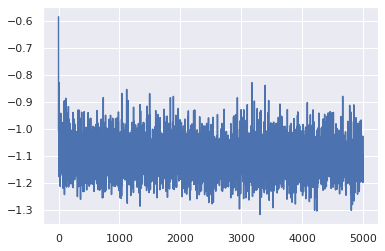

In [ ]:
plt.plot(batch_loss)

sample: 100%|██████████| 5100/5100 [04:43<00:00, 17.97it/s, 31 steps of size 1.61e-01. acc. prob=0.90]
/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)


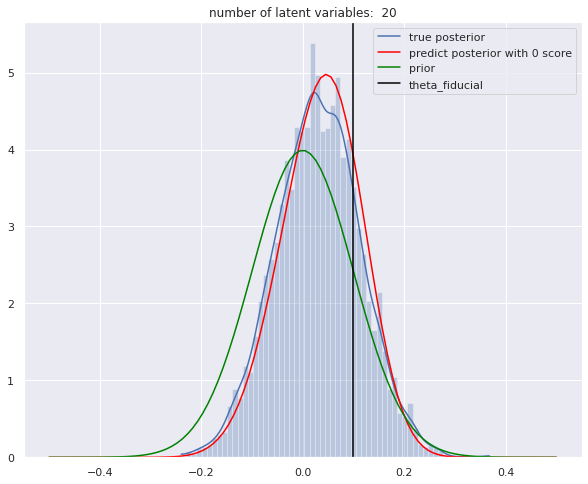

In [ ]:
# create fiducial 
theta_fid = 0.1
model = partial(
    simulator_1,
    nb_latent_variables=20
)
fiducial_model = condition(model, {'theta': theta_fid})
sample_fiducial = seed(fiducial_model, jax.random.PRNGKey(30))
x_0 = sample_fiducial()

# create true posterior
model = partial(simulator_1, nb_latent_variables = nb_latent_variables)
observed_model = condition(model, {'y': x_0})
nuts_kernel = numpyro.infer.NUTS(observed_model,
                                 init_strategy=numpyro.infer.init_to_median,
                                 max_tree_depth=6,
                                 step_size=0.02)
mcmc = numpyro.infer.MCMC(nuts_kernel, 
                          num_warmup=100, 
                          num_samples=5000)
mcmc.run(jax.random.PRNGKey(3))
res = mcmc.get_samples()
reference_samples = res['theta']

prior = tfd.Normal(0,0.1)

# plot results
theta_axis = jnp.linspace(-0.5, 0.5, 100)
pred_true = jax.vmap(
    lambda theta: nvp_nd_npe_prob.apply(
      params_nd_npe,
      theta.reshape([1, 1]),
      x_0.reshape([1, 1])
    )
)(theta_axis)

plt.figure(figsize=(10, 8))
plt.title('number of latent variables: % d' % nb_latent_variables)
plt.hist(
    reference_samples,
    60,
    alpha=0.3,
    density=True
)
az.plot_kde(
    np.array(reference_samples),
    label='true posterior'
)
plt.plot(
    theta_axis,
    pred_true,
    label='predict posterior with %d score' % score_weight,
    color='red'
)
plt.plot(
    theta_axis,
    prior.prob(theta_axis),
    label='prior',
    color='green'
)
plt.axvline(
    theta_fid,
    label='theta_fiducial',
    color='black'
    )
plt.legend()